# Data extension

We performed STALOC to extend the gene throughout of mouse visual cortex STARmap dataset. The raw STARmap dataset of mouse visual cortex can be downloaded from [Dropbox](https://www.dropbox.com/sh/f7ebheru1lbz91s/AADm6D54GSEFXB1feRy6OSASa/visual_1020/20180505_BY3_1kgenes?dl=0&subfolder_nav_tracking=1). The raw scRNA-seq dataset and cell type labels of mouse VISp can be downloaded from [Dropbox]( https://www.dropbox.com/sh/q687ajyvnkbtwkc/AACxlJAsJaJ5DVe-2mx3cbW2a?dl=0) and [Github](https://github.com/spacetx-spacejam/data/blob/master/mouseVISp_cluster_summary.csv). The anndata object of processed datasets can be downloaded from [Google Drive](https://drive.google.com/drive/folders/1IYDpYgQwcVEAJCIS76hcmqREi_4hvB39).

In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
import pandas as pd
import scanpy as sc
import STALocator
import scipy.sparse as sp

## Read data

In [2]:
# Read ST dataset.
st_data_path = '../data/T5_ST/'

## Read the expression data as anndata object with cell type labels.
adata_ST=sc.read(os.path.join(st_data_path,"STARmap_20180505_BY3_1k.h5ad"))
adata_ST.obs["Y"]=adata_ST.obs["Y"]*(-1)
adata_ST.obsm["spatial"]=adata_ST.obs[["X","Y"]].to_numpy()

In [ ]:
# You can also read the processed h5ad file directly to run the model more easily.
#st_data_path = '../data/T5_ST/'
#adata_ST=sc.read(os.path.join(st_data_path, "mvc_starmap.h5ad"))

In [3]:
adata_ST

AnnData object with n_obs × n_vars = 1207 × 1020
    obs: 'Total_counts', 'X', 'Y', 'label'
    uns: 'label_colors'
    obsm: 'spatial'

In [4]:
# Read scRNA-seq dataset.
sc_data_path="../data/T5_sc/"

## Read the expression data.
count=pd.read_csv(os.path.join(sc_data_path,"exon.counts.csv"), index_col=0)

## Read the meta data with cell type labels and filter out cells that are not in the meta data
meta=pd.read_csv(os.path.join(sc_data_path,"mouseVISp_cluster_summary.csv"), index_col=0)
count=count.loc[:,meta.index]

## Expression data must be transformed to anndata object, and meta data must be added to it.
adata_sc=sc.AnnData(count.T, obs=meta)
adata_sc.X=sp.csr_matrix(adata_sc.X)
adata_sc.var_names_make_unique()
adata_sc.obs_names_make_unique()

## Cell type or spatial domain labels must be additionally stored in 'celltype' if they exist.
adata_sc.obs["celltype"]=adata_sc.obs["subclass"]

In [ ]:
# You can also read the processed h5ad file directly to run the model more easily.
#sc_data_path="../data/T5_sc/"
#adata_sc=sc.read(os.path.join(sc_data_path, "mvisp_scRNAseq.h5ad"))

In [5]:
adata_sc

AnnData object with n_obs × n_vars = 11759 × 45768
    obs: 'consensus_cluster', 'reference_cluster', 'reference_color', 'broad_class', 'subclass', 'merged_cluster_smFISH', 'merged_cluster_ISS', 'celltype'

In [6]:
sc.pp.filter_genes(adata_ST, min_cells=3)
sc.pp.filter_genes(adata_sc, min_cells=3)

## Run model

In [7]:
experiment_path="T5"
if not os.path.exists(experiment_path):
    os.makedirs(experiment_path)

In [8]:
model = STALocator.model.Model(resolution="high", batch_size=200, train_epoch=5000, seed=1234, lambdacos=15, lambdaSWD = 2, 
                               model_path = "T5/models", data_path = "T5/data", result_path = "T5/results", device="cuda:0")

In [9]:
model.preprocess(adata_sc, adata_ST)

Finding highly variable genes...
Normalizing and scaling...
Dimensionality reduction via PCA...


In [10]:
model.train(metric="cosine", reg=0.1, numItermax=10)

Begining time:  Fri Mar 15 18:13:17 2024
step 0, total_loss=270.4201, loss_D=7.4630, loss_GAN=2.4428, loss_AE=13.0924, loss_cos=1.9690, loss_LA=9.9713, loss_SWD=3.9026
step 500, total_loss=20.8122, loss_D=1.4240, loss_GAN=6.6552, loss_AE=0.5802, loss_cos=0.4511, loss_LA=0.1199, loss_SWD=0.1948
step 1000, total_loss=18.7572, loss_D=0.9540, loss_GAN=7.1444, loss_AE=0.4784, loss_cos=0.3885, loss_LA=0.0731, loss_SWD=0.1357
step 1500, total_loss=18.1083, loss_D=1.0405, loss_GAN=7.4177, loss_AE=0.4198, loss_cos=0.3768, loss_LA=0.0674, loss_SWD=0.0829
step 2000, total_loss=18.0049, loss_D=0.9570, loss_GAN=7.4052, loss_AE=0.3864, loss_cos=0.3959, loss_LA=0.0635, loss_SWD=0.0809
step 2500, total_loss=16.2073, loss_D=0.7321, loss_GAN=8.5552, loss_AE=0.3090, loss_cos=0.2690, loss_LA=0.0430, loss_SWD=0.0483
step 3000, total_loss=15.1083, loss_D=0.3922, loss_GAN=9.0419, loss_AE=0.2915, loss_cos=0.1791, loss_LA=0.0352, loss_SWD=0.0566
step 3500, total_loss=14.8187, loss_D=0.5427, loss_GAN=8.9117, lo

In [11]:
model.eval(retain_prop=0.1)

Enhanced ST dataset has been saved!


In [12]:
adata_total = model.adata_total
adata_sc = model.adata_A_input
adata_ST = model.adata_B_input
adata_ST_pm = model.adata_ST_pm

In [13]:
adata_ST_pm

AnnData object with n_obs × n_vars = 1207 × 38048
    obs: 'Total_counts', 'X', 'Y', 'label', 'batch'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    obsm: 'spatial'

## Visualization of data extension results

In [14]:
select_gene1=["Mbp","Pcp4","Zmat4","Lamp5"]
select_gene2=["Foxp2","Bcl11b","Kcnh5","Igf2"]

[<AxesSubplot:title={'center':'Mbp'}, xlabel='spatial1', ylabel='spatial2'>,
 <AxesSubplot:title={'center':'Pcp4'}, xlabel='spatial1', ylabel='spatial2'>,
 <AxesSubplot:title={'center':'Zmat4'}, xlabel='spatial1', ylabel='spatial2'>,
 <AxesSubplot:title={'center':'Lamp5'}, xlabel='spatial1', ylabel='spatial2'>]

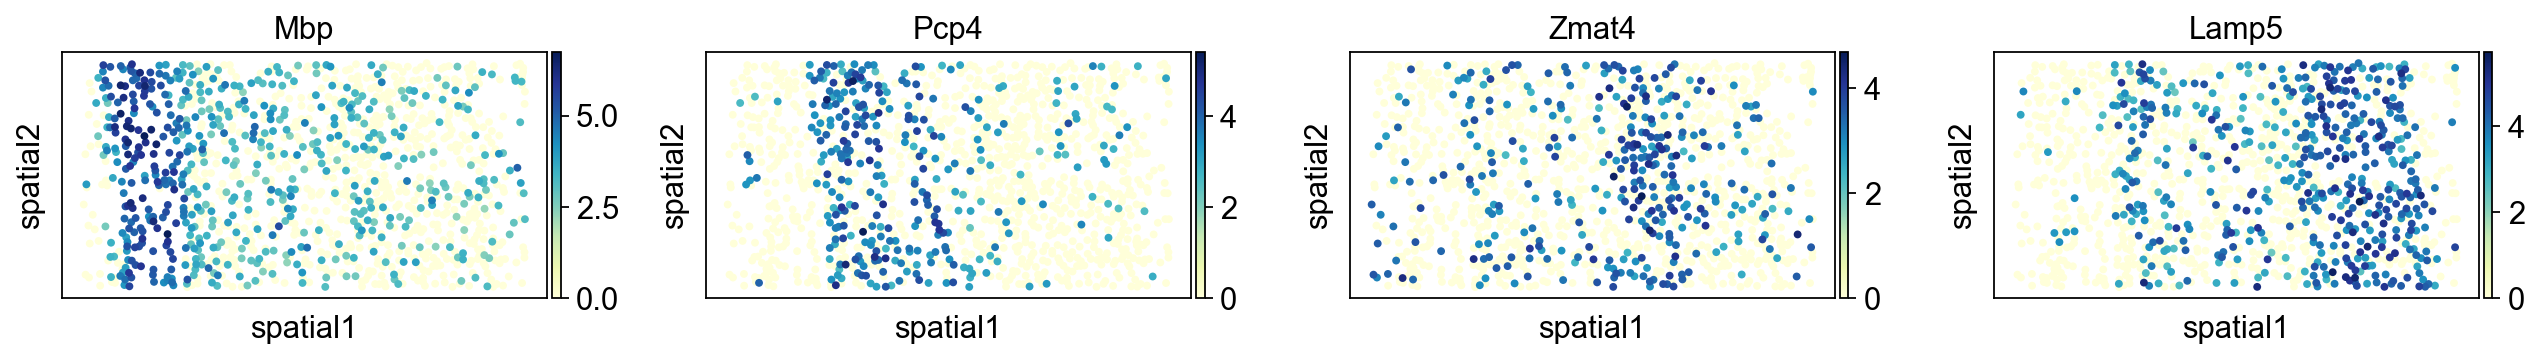

In [16]:
sc.set_figure_params(dpi=80, figsize=(4, 2))
sc.pl.embedding(adata_ST, basis='spatial', color=select_gene1, color_map="YlGnBu", s=50, show=False)

[<AxesSubplot:title={'center':'Mbp'}, xlabel='spatial1', ylabel='spatial2'>,
 <AxesSubplot:title={'center':'Pcp4'}, xlabel='spatial1', ylabel='spatial2'>,
 <AxesSubplot:title={'center':'Zmat4'}, xlabel='spatial1', ylabel='spatial2'>,
 <AxesSubplot:title={'center':'Lamp5'}, xlabel='spatial1', ylabel='spatial2'>]

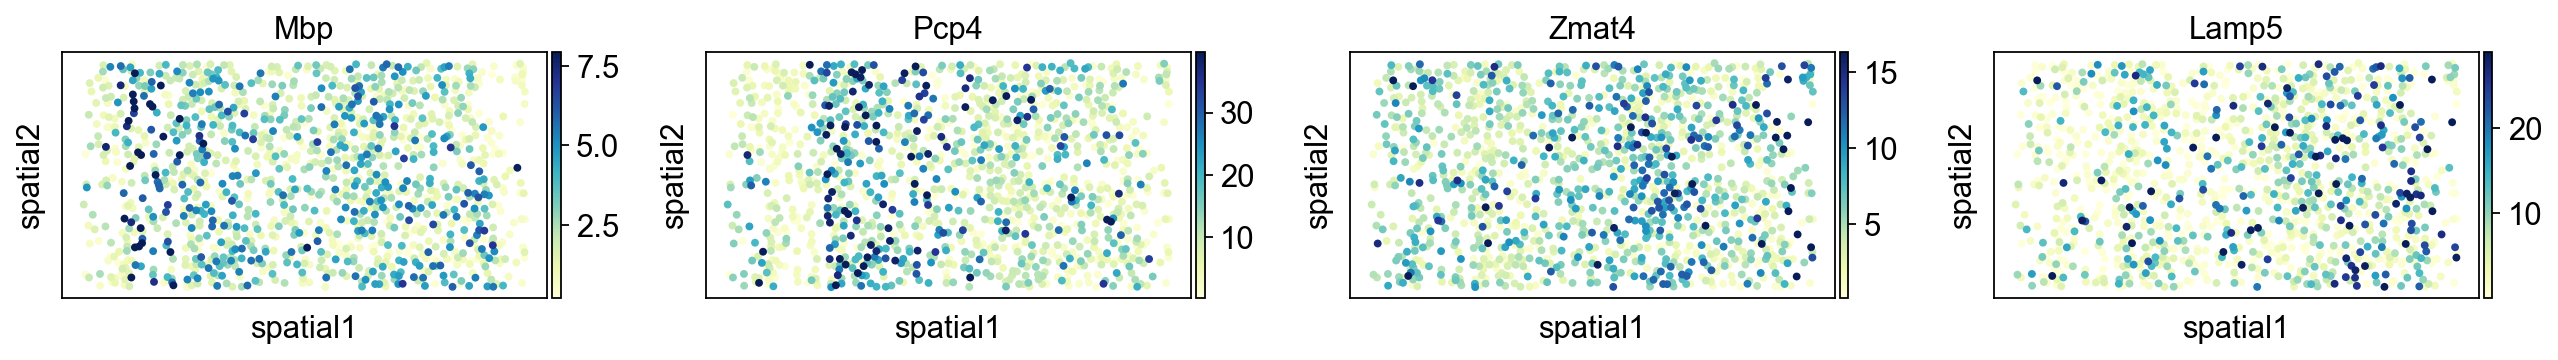

In [17]:
sc.set_figure_params(dpi=80, figsize=(4, 2))
sc.pl.embedding(adata_ST_pm, basis="spatial", color=select_gene1, color_map="YlGnBu", s=50, show=False, vmax="p98")

[<AxesSubplot:title={'center':'Foxp2'}, xlabel='spatial1', ylabel='spatial2'>,
 <AxesSubplot:title={'center':'Bcl11b'}, xlabel='spatial1', ylabel='spatial2'>,
 <AxesSubplot:title={'center':'Kcnh5'}, xlabel='spatial1', ylabel='spatial2'>,
 <AxesSubplot:title={'center':'Igf2'}, xlabel='spatial1', ylabel='spatial2'>]

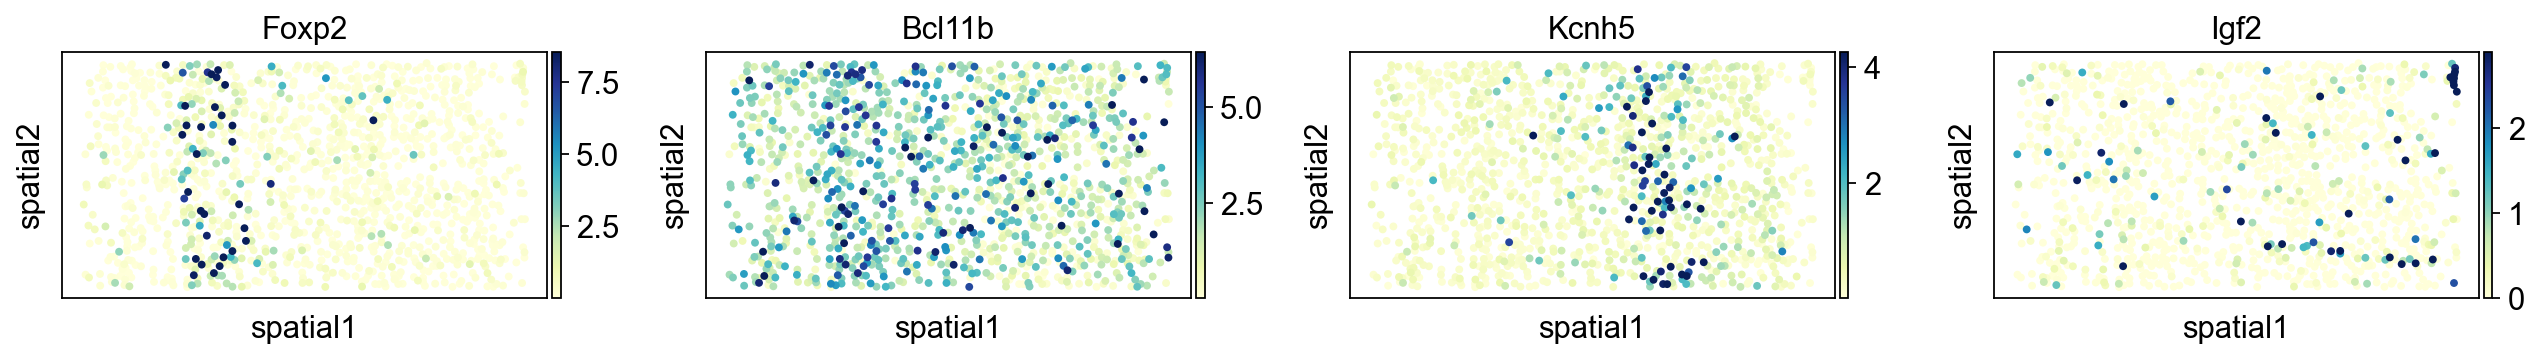

In [18]:
sc.set_figure_params(dpi=80, figsize=(4, 2))
sc.pl.embedding(adata_ST_pm, basis="spatial", color=select_gene2, color_map="YlGnBu", s=50, show=False, vmax="p98")

In [19]:
label_order = ['HPC', 'CC', 'L6', 'L5', 'L4', 'L2/3', 'L1']

{'mainplot_ax': <AxesSubplot:>,
 'color_legend_ax': <AxesSubplot:title={'center':'Median expression\nin group'}>}

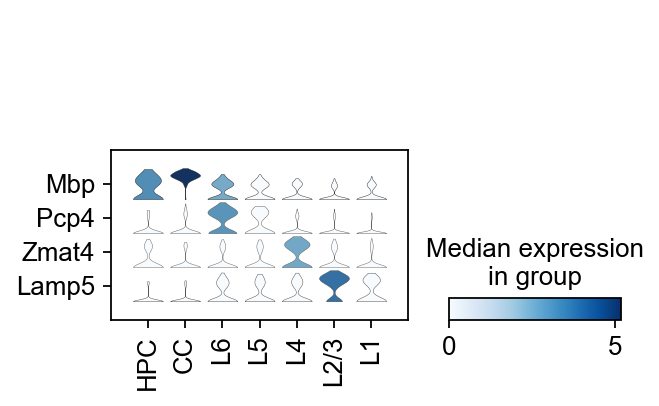

In [20]:
sc.pl.stacked_violin(adata_ST, var_names=select_gene1, categories_order=label_order, groupby='label', 
                     use_raw=False, swap_axes=True, show=False)

{'mainplot_ax': <AxesSubplot:>,
 'color_legend_ax': <AxesSubplot:title={'center':'Median expression\nin group'}>}

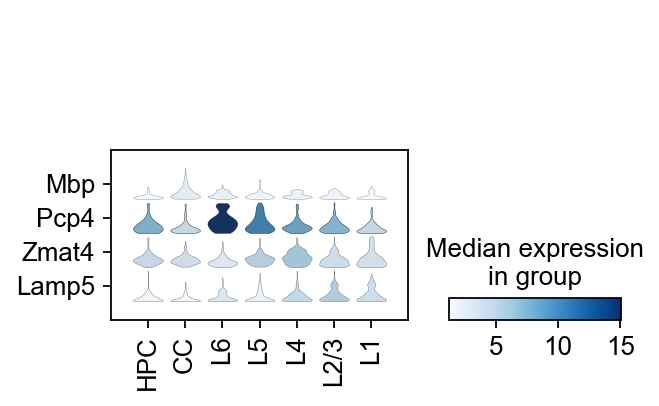

In [21]:
sc.pl.stacked_violin(adata_ST_pm, var_names=select_gene1, categories_order=label_order, groupby='label', 
                     use_raw=False, swap_axes=True, show=False)

{'mainplot_ax': <AxesSubplot:>,
 'color_legend_ax': <AxesSubplot:title={'center':'Median expression\nin group'}>}

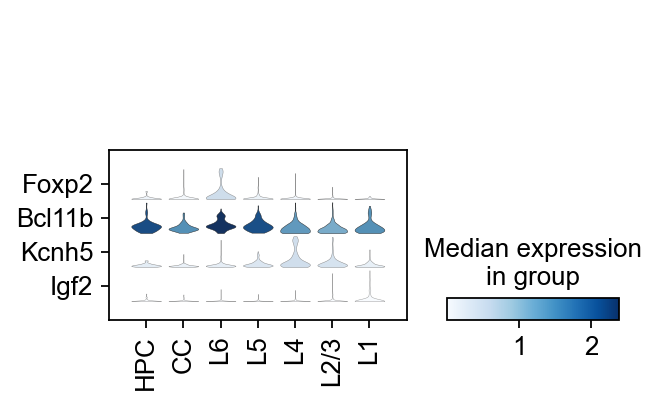

In [22]:
sc.pl.stacked_violin(adata_ST_pm, var_names=select_gene2, categories_order=label_order, groupby='label', 
                     use_raw=False, swap_axes=True, show=False)

## Label transfer

In [23]:
trans_label=model.trans_label

In [24]:
adata_ST.obs.loc[trans_label.index, trans_label.columns]=trans_label

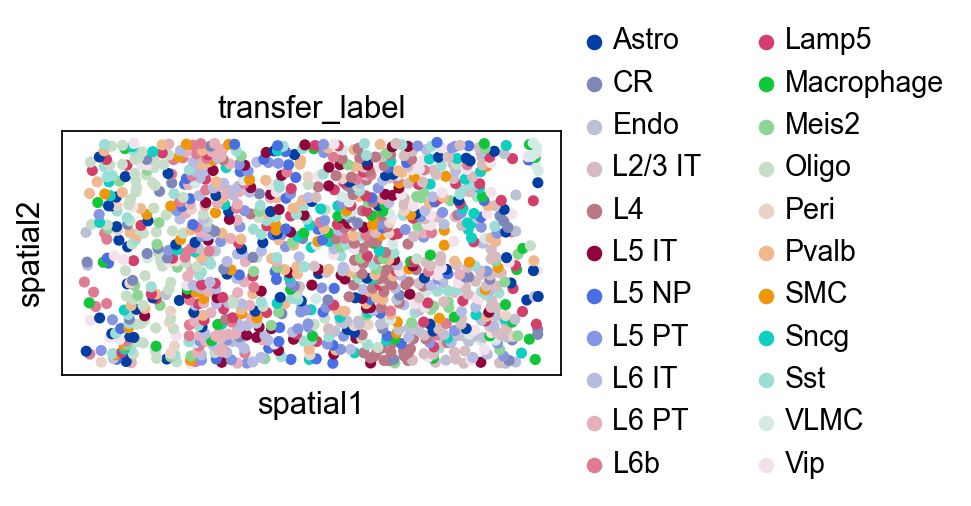

In [25]:
sc.set_figure_params(dpi=80, figsize=(4, 2))
sc.pl.embedding(adata_ST, basis="spatial", color="transfer_label", s=100)

## Identifying spatially variable genes (SVGs)

This part needs [Hotspot](https://github.com/Yoseflab/Hotspot) package.

In [26]:
import hotspot
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
from tqdm import tqdm
from matplotlib_venn import venn2, venn2_circles

In [27]:
sc.pp.filter_genes(adata_ST, min_cells=1)
print('After flitering: ', adata_ST.shape)

After flitering:  (1207, 1020)


In [28]:
sc.pp.filter_genes(adata_ST_pm, min_cells=1)
print('After flitering: ', adata_ST_pm.shape)

After flitering:  (1207, 38048)


In [29]:
adata_ST.X=sp.csc_matrix(adata_ST.X)
adata_ST_pm.X=sp.csc_matrix(adata_ST_pm.X)

In [30]:
hs = hotspot.Hotspot(adata_ST,model='danb',latent_obsm_key="spatial")
hs.create_knn_graph(weighted_graph=False, n_neighbors=10)
hs_results = hs.compute_autocorrelations()
hs_genes = hs_results.loc[hs_results.FDR < 0.001].index

100%|█████████████████████████████████████████████████████████████████████████████| 1020/1020 [00:01<00:00, 825.46it/s]


In [31]:
hs_staloc = hotspot.Hotspot(adata_ST_pm,model='danb',latent_obsm_key="spatial")
hs_staloc.create_knn_graph(weighted_graph=False, n_neighbors=10)
hs_staloc_results = hs_staloc.compute_autocorrelations()
hs_staloc_genes = hs_staloc_results.loc[hs_staloc_results.FDR < 0.001].index

100%|██████████████████████████████████████████████████████████████████████████| 38048/38048 [00:13<00:00, 2753.54it/s]


In [32]:
hs_results.to_csv("T5/results/hotspot_results_raw.csv")
hs_staloc_results.to_csv("T5/results/hotspot_results_staloc.csv")

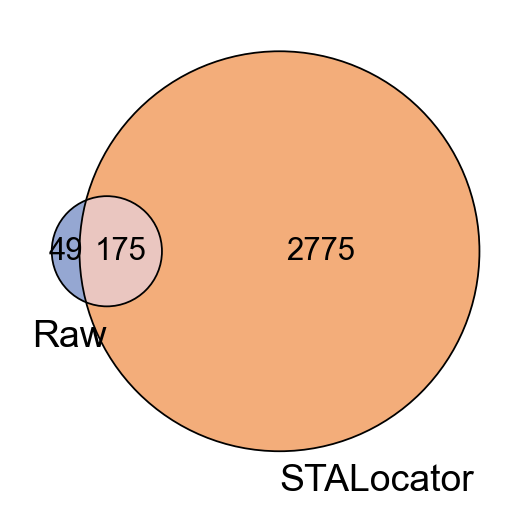

In [33]:
sc.set_figure_params(dpi=80, figsize=(4, 4))
g=venn2(subsets = [set(hs_genes), set(hs_staloc_genes)], set_labels = ["Raw","STALocator"],
        set_colors=("#4f6db4", "#ec7722"),alpha=0.6,normalize_to=1.0)
g=venn2_circles(subsets = [set(hs_genes), set(hs_staloc_genes)], linewidth=0.8, color="black")
plt.show()